# Impact of Promotion on Employee Performance

### Introduction

The link between management of employees and sustainable competitive advantage for organizations have been well documented in the literature.  Competitive advantage attained through HR policies is likely to be sustained because a company's policies may not be replicable easily by another company.  For instance, the mere fact that company A achieved improved employee performance through training or higher compensation or promotion does not necessarily mean that company B will also attain competitive advantage taking the same route.

HR professionals are always concered with recruiting the right fit in order to maximize returns to their investments in the employees.  Promotion is one of the strategies used by organizations to achieve employee productivity, however, it may not be that certain that all employees promoted will respond appropriately to the strategy.  Carrying out an experiment to understand this issue may not be ethical, however, from historical observational data, one can construct an experimental data to examine the effect of promotion on employee performance.

There are many HR datasets online, but I found this [Particular dataset](https://studio.azureml.net/Home/ViewWorkspaceCached/90abf1900f5e407cbbc7ccc08102e59a?#Workspaces/Experiments/Experiment/90abf1900f5e407cbbc7ccc08102e59a.f-id.4c495001b300451a839cef4ea67474b6/ViewExperiment) to be useful for our analysis.

Again, there are many libraries available in analyzing causal effects such as causalml by Uber, DoWhy and ECONML by Microsoft, causallib by IBM.  For this analsis, we shall employ causallib library to take advatage of its various quasi-experimentatal methods.

### Import the necessary libraries

In [1]:
import causallib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Import the data and explore the distribution

In [2]:
data = pd.read_csv('Employee_promotion.csv')
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
data.shape

(54808, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


#### Observations from the dataset

* previous_year_rating has some missing data which we will remove
* The data contain the variable 'is_promoted' which we shall use as our treatment variable
* The data contain the variable 'KPIs_met >80%' which we shall use as our performance variable
* We shall drop employee_id variable
* We shall rename variables with Underscore

In [5]:
data = data.drop('employee_id',axis=1)

In [6]:
# Drop na

data = data.dropna()

In [7]:
data.shape

(48660, 13)

In [8]:
# rename colums

new_names = {'length_of_service':'Experience','KPIs_met >80%':'Performance',
             'awards_won?':'awards','is_promoted':'Treatment','previous_year_rating':'rating_ly',
             'avg_training_score':'trainingscore','no_of_trainings':'trainings','recruitment_channel':'channel'}

data.rename(columns=new_names,inplace=True)

In [9]:
# Check the cleaned data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48660 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     48660 non-null  object 
 1   region         48660 non-null  object 
 2   education      48660 non-null  object 
 3   gender         48660 non-null  object 
 4   channel        48660 non-null  object 
 5   trainings      48660 non-null  int64  
 6   age            48660 non-null  int64  
 7   rating_ly      48660 non-null  float64
 8   Experience     48660 non-null  int64  
 9   Performance    48660 non-null  int64  
 10  awards         48660 non-null  int64  
 11  trainingscore  48660 non-null  int64  
 12  Treatment      48660 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.2+ MB


### Experimental Approach

In [10]:
# Check for distribution of treatment variable

data['Treatment'].value_counts()

0    44428
1     4232
Name: Treatment, dtype: int64

In [11]:
data['Performance'].value_counts()

0    31314
1    17346
Name: Performance, dtype: int64

About 10% of the employees have received promotion while a greater proprtion of them have not, we shall draw a random sample of about 80% from those with promotion and draw an equivalent sample from those without promotion.

In [12]:
control_group = data[data['Treatment']==0].sample(n=4500,random_state=42)
treatment_group = data[data['Treatment']==1].sample(frac=0.8,random_state=42)

In [13]:
control_group['Treatment'].value_counts()

0    4500
Name: Treatment, dtype: int64

In [14]:
treatment_group['Treatment'].value_counts()

1    3386
Name: Treatment, dtype: int64

In [15]:
# Merge the datasets

df = pd.concat([control_group,treatment_group],axis=0)

In [16]:
df['Treatment'].value_counts(normalize=True)

0    0.570631
1    0.429369
Name: Treatment, dtype: float64

In [17]:
df.head()

,department,region,education,gender,channel,trainings,age,rating_ly,Experience,Performance,awards,trainingscore,Treatment
33068,Operations,region_5,Bachelor's,m,sourcing,1,32,4.0,5,0,0,61,0
50346,Technology,region_11,Bachelor's,f,other,1,35,1.0,4,1,0,76,0
43021,Operations,region_26,Bachelor's,m,other,1,28,3.0,4,0,0,59,0
30680,Technology,region_15,Bachelor's,m,other,2,40,5.0,13,1,0,78,0
28142,Sales & Marketing,region_2,Bachelor's,f,sourcing,1,40,3.0,11,0,0,54,0


### Initial Analysis 

We compare the performance of influence of promotion without controlling for the counfounding factors

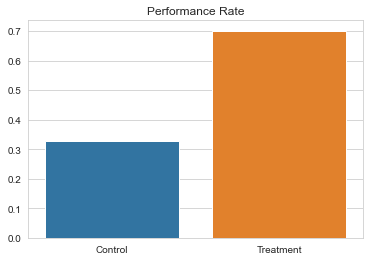

Difference between Control and Treatment 0.37312


In [18]:
sns.set_style("whitegrid")
sns.barplot(x = ['Control', 'Treatment'], y = df.groupby('Treatment')['Performance'].mean().values)
plt.title('Performance Rate')
plt.show()
print(f'Difference between Control and Treatment {np.round(df.groupby("Treatment")["Performance"].mean()[1] - df.groupby("Treatment")["Performance"].mean()[0], 5)}')

In [19]:
### Convert the dataset to dummy variables

data_df = pd.get_dummies(df,drop_first=True,prefix_sep=('*'))

In [20]:
data_df.shape

(7886, 54)

In [21]:
# Check balancing of covariates

data_df.groupby('Treatment').mean()

,trainings,age,rating_ly,Experience,Performance,awards,trainingscore,department*Finance,department*HR,department*Legal,...,region*region_5,region*region_6,region*region_7,region*region_8,region*region_9,education*Below Secondary,education*Master's & above,gender*m,channel*referred,channel*sourcing
Treatment,,,,,,,,,,,,,,,,,,,,,
0,1.268889,35.734222,3.283556,6.419778,0.328000,0.013111,62.727111,0.048889,0.043778,0.019556,...,0.013556,0.011778,0.087333,0.011556,0.008000,0.012000,0.299111,0.701778,0.017333,0.417556
1,1.204962,34.896929,3.987301,6.049321,0.701122,0.121087,71.323095,0.045186,0.025103,0.009746,...,0.006793,0.007383,0.112817,0.012404,0.002067,0.008269,0.339634,0.674542,0.031305,0.423509


A cursory look at the distribution of the covariates between the treatment group and untreated groups shows some imbalance, for instance, trainingscore for the control group is 9 points lower than those in treatment group, similarly for awards, rating_ly, age, department*HR etc.  Hence, there is a need to ensure covariate balance before accepting our initial result of the effect of promotion on performance.

causallib provide us with several methods of ensuring that we get balancing of covariates which we shall implement here

In [22]:
#  Variable selection
X = df.drop(['Performance','Treatment'],axis=1)
X = pd.get_dummies(X,drop_first=True,prefix_sep=('*'))
y = df['Performance']
a = df['Treatment']

In [23]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from matplotlib import pyplot as plt
from causallib.estimation import (
    PropensityFeatureStandardization,
    WeightedStandardization,
    AIPW,
    IPW,
    MarginalOutcomeEstimator,
    Standardization,
    StratifiedStandardization,
    Matching,
    PropensityMatching,
)
from causallib.preprocessing.transformers import MatchingTransformer


def learner(): return LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=5000)


def makeipw(): return IPW(learner=learner())
def makestd(): return StratifiedStandardization(learner=LinearRegression())


all_estimators = [
    MarginalOutcomeEstimator(learner=LinearRegression()),
    Matching(with_replacement=False),
    PropensityMatching(learner=learner(), caliper=0.1),
    IPW(learner=learner()),
    Standardization(learner=LinearRegression()),
    StratifiedStandardization(learner=LinearRegression()),
    PropensityFeatureStandardization(makestd(), makeipw()),
    WeightedStandardization(makestd(), makeipw()),
    AIPW(makestd(), makeipw()),
]


def get_all_estimates(X, a, y):
    estimates = {}
    for estimator in all_estimators:
        estimator.fit(X, a, y)
        estimator_name = estimator.__class__.__name__
        estimates[estimator_name] = estimator.estimate_population_outcome(
            X, a, y)
    estimates_df = pd.concat(estimates, axis=1).T
    return estimates_df

In [24]:
all_estimates = get_all_estimates(X, a, y)
all_estimates.assign(ATE=all_estimates[1] - all_estimates[0])

,0,1,ATE
MarginalOutcomeEstimator,0.328000,0.701122,0.373122
Matching,0.350856,0.701122,0.350266
PropensityMatching,0.431524,0.815369,0.383845
IPW,0.390418,0.791586,0.401168
Standardization,0.322074,0.708998,0.386923
StratifiedStandardization,0.386640,0.757062,0.370423
PropensityFeatureStandardization,0.378432,0.677903,0.299471
WeightedStandardization,0.388272,0.805236,0.416964
AIPW,0.389532,0.793782,0.404250


### Restricting the sample with Matching

Given that our covariates were not balanced, we need to get a balanced covariate sample to get the actual impact of our treatment on employee performance.  One method of achieving this is to restrict our sample to the matched cases.

In [26]:
from causallib.preprocessing.transformers import PropensityTransformer
propensity_transform = PropensityTransformer(learner=learner(), include_covariates=True)

In [27]:
mt = MatchingTransformer(with_replacement=False, propensity_transform=propensity_transform)
Xm, am, ym = mt.fit_transform(X, a, y)
print(f"Transforming data from {X.shape[0]} samples to {Xm.shape[0]} samples by matching without replacement.")

Transforming data from 7886 samples to 6772 samples by matching without replacement.


In [31]:
all_estimates_matched = get_all_estimates(Xm, am, ym)
all_estimates_matched.assign(ATE=all_estimates_matched[1] - all_estimates_matched[0])

,0,1,ATE
MarginalOutcomeEstimator,0.349084,0.701122,0.352038
Matching,0.349084,0.701122,0.352038
PropensityMatching,0.474454,0.793414,0.318960
IPW,0.399299,0.788556,0.389258
Standardization,0.332748,0.717459,0.384711
StratifiedStandardization,0.411117,0.747205,0.336088
PropensityFeatureStandardization,0.402193,0.658116,0.255923
WeightedStandardization,0.409665,0.790908,0.381243
AIPW,0.412336,0.789477,0.377141


The results of all the estimators with matched samples were not signficantly different when compared with the unmatched samples. Putting the results of all of them together, the ATE is still above 30%

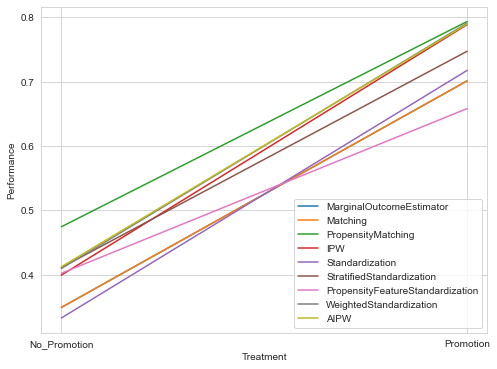

In [32]:
f, ax = plt.subplots(figsize=(8, 6))
all_estimates_matched.T.plot(ax=ax)
plt.ylabel(y.name)
plt.xlabel(a.name)
plt.xticks([0, 1], ["No_Promotion", "Promotion"]);